## Model
#### In this Jupyter Notebook, we address the imbalance data to three dataset: lower clean data, downsample and upsample, augment data.
#### And using the original and these three data set to train our baseline model and BERT.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from googletrans import Translator
import nltk
import random
import time

## data

In [2]:
## import train and test
train = pd.read_csv('C:\\Users\\admin\\Desktop\\capstone\\project\\train.csv\\train.csv')
test = pd.read_csv('C:\\Users\\admin\\Desktop\\capstone\\project\\test.csv\\test.csv')

## Test data

In [4]:
## import test label
test_labels = pd.read_csv('C:\\Users\\admin\\Desktop\\capstone\\project\\test_labels.csv\\test_labels.csv')

In [5]:
## combine test and test label
test = pd.merge(test, test_labels, how='left', on='id')
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [6]:
## Because there are columns label -1, that means when you upload to Kaggle, it doesn't count into point
## However, that means we don't know the answer, so we will filter the comment that all label -1
test = test[(test.toxic!=-1)& (test.severe_toxic!=-1)& (test.obscene!=-1)& (test.threat!=-1)& (test.insult!=-1)& (test.identity_hate!=-1)]

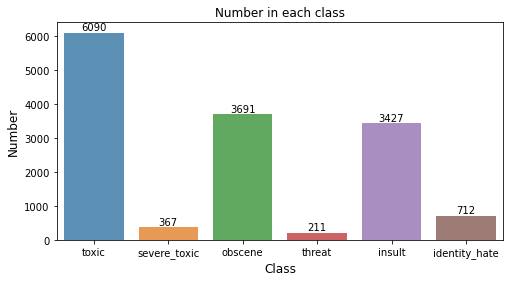

In [7]:
## check the number in each class
x=test.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number in each class")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [10]:
## output test data
test.to_csv('test_new.csv')

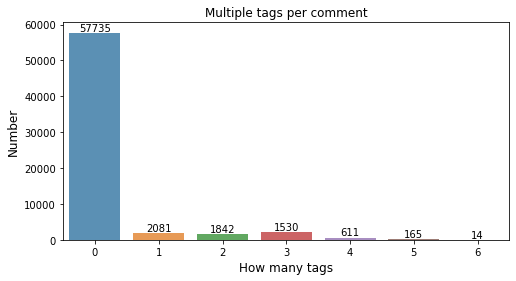

In [7]:
## check multiple tagging
rowsums=test.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('Number', fontsize=12)
plt.xlabel('How many tags', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Train data
#### address the train data to original, lower the number of clean data, balance, augment data

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


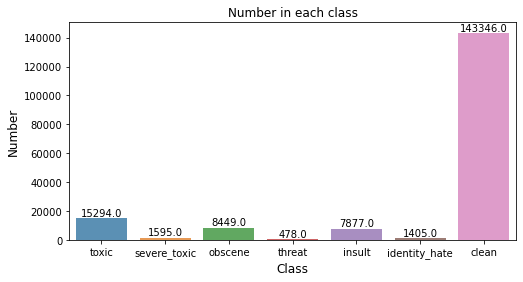

In [8]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())
## calculate
x=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number in each class")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

##### The number in each class in our original data

#### lower the clean to 10000

In [28]:
## lower the clean to 10000
## filter clean
clean = train[train['clean']==True].sample(10000)
## filter notean
data_lower = train[train['clean']==False]
## combine
data_lower = data_lower.append(clean)
data_lower = shuffle(data_lower)
data_lower.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
142280,f903cb820b6ff4c5,sexual orientation mindset lol. Go die now. Th...,1,0,0,0,1,0,False
77793,d058a3d7dc0964b1,"""\n\n Message? What message? I didn't realise ...",1,0,0,0,0,0,False
110056,4caeda8063a342b5,"Also, I burn jews for fun.",1,0,0,1,0,1,False
138917,e7726cecd9e8882d,"Paul Thornton\nHi, hope you are well, the Paul...",0,0,0,0,0,0,True
113764,605bc006919e6d2d,"and the website where i got it from,",0,0,0,0,0,0,True


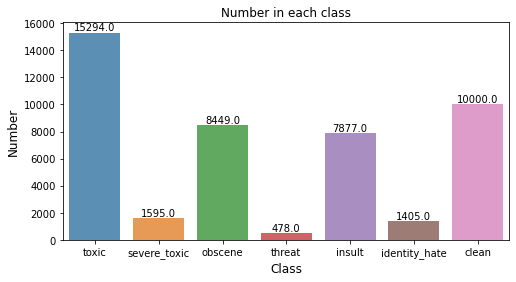

In [29]:
## calculate
x=data_lower.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number in each class")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

##### We can see the number of clean reduce to 10000

#### Downsample and upsample

In [56]:
## Downsample and upsample
## only threat
threat = train[(train['threat']==1) & (train['identity_hate']==0) & (train['severe_toxic']==0)& (train['toxic']==0)& (train['obscene']==0)& (train['insult']==0)]
print('only threat:', len(threat))
## only identity_hate
identity_hate = train[(train['identity_hate']==1) & (train['threat']==0) & (train['severe_toxic']==0)& (train['toxic']==0)& (train['obscene']==0)& (train['insult']==0)]
print('only identity_hate:', len(identity_hate))
## only severe_toxic
severe_toxic = train[(train['severe_toxic']==1) & (train['threat']==0) & (train['identity_hate']==0)& (train['toxic']==0)& (train['obscene']==0)& (train['insult']==0)]
print('only severe_toxic:', len(severe_toxic))
## only threat and identity_hate
threat_hate = train[(train['severe_toxic']==0) & (train['threat']==1) & (train['identity_hate']==1)& (train['toxic']==0)& (train['obscene']==0)& (train['insult']==0)]
print('only threat and identity_hate:', len(threat_hate))

only threat: 22
only identity_hate: 54
only severe_toxic: 0
only threat and identity_hate: 0


In [35]:
## base on the data distribution we have, it impossible to upsample and downsample to let each class have similar number
## the only thing we can do is to let the more quantity drop a little, the less quantity rise a little

In [58]:
## 50 times only threat and identity_hate
tmp = train[(train['threat']==1) | (train['identity_hate']==1) | (train['severe_toxic']==1)]
tmp = tmp[(tmp['toxic']==0) & (tmp['obscene']==0) & (tmp['insult']==0)]  
tmp = pd.concat([tmp]*50).sort_index()
## lower clean
balance = pd.concat([train, tmp])
clean = balance[balance['clean']==True].sample(15000)
balance = balance[(balance['clean']==False)]
balance = pd.concat([balance, clean])

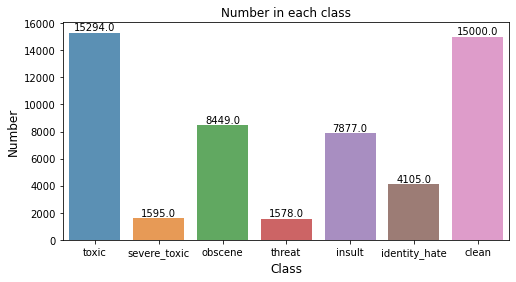

In [59]:
## check the number in each class
x=balance.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number in each class")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

##### lower the clean and increase a little number of severe_toxic, threat, and identity_hate

#### data augmentation using language translation

In [112]:
## set the language we want to translate
language = ["es", 'zh-tw', "de", "fr", "ar", "te", "hi", "ja", "fa", 'ru', "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps", 'pt', 'ko']
## define the function to transfer the comment to one language and translate back to English
def data_augmentation(message, language):
    augmented_messages = []
    for i in range(len(language)) :
        try:
            translator = Translator()
            text = translator.translate(message, dest=language[i])
            text = text.text
            translator = Translator()
            text = translator.translate(text, dest='en')
            text = text.text
        except:
            text = message
        
        augmented_messages.append(str(text))

    return augmented_messages

In [121]:
## augment threat
threat = train[(train['threat']==1) & (train['identity_hate']==0) & (train['severe_toxic']==0)& (train['toxic']==0)& (train['obscene']==0)& (train['insult']==0)]
t1 = time.time()
threat_aug = []
for i in threat['comment_text']:
    threat_aug.extend(data_augmentation(i, language))
t2 = time.time()
print('spend:', str(t2 - t1), ' seconds')

spend: 1000.0014510154724  seconds


In [139]:
## concact with id, class
threat_aug_df = pd.DataFrame(threat_aug)
threat_tmp = pd.DataFrame(np.repeat(threat.values,20,axis=0))
threat_tmp.columns = threat.columns
threat_tmp['comment_text'] = threat_aug_df
threat_tmp.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,09eb7d87b8c24ca5,Please stop. If you continue to ignore our pol...,0,0,0,1,0,0,False
1,09eb7d87b8c24ca5,please stop. If you continue to ignore our pol...,0,0,0,1,0,0,False
2,09eb7d87b8c24ca5,Please stop. If you continue to ignore our gui...,0,0,0,1,0,0,False
3,09eb7d87b8c24ca5,Please stop. If you continue to ignore our pol...,0,0,0,1,0,0,False
4,09eb7d87b8c24ca5,please stop. If you continue to ignore our pol...,0,0,0,1,0,0,False


In [141]:
## concact back to table
train_aug = pd.concat([train, threat_tmp])
len(train_aug)

160011

In [122]:
## augment identity_hate
identity_hate = train[(train['identity_hate']==1) & (train['threat']==0) & (train['severe_toxic']==0)& (train['toxic']==0)& (train['obscene']==0)& (train['insult']==0)]
t1 = time.time()
identity_hate_aug = []
for i in identity_hate['comment_text']:
    identity_hate_aug.extend(data_augmentation(i, language))
t2 = time.time()
print('spend:', str(t2 - t1), ' seconds')

spend: 2106.8702116012573  seconds


In [142]:
## concact with id, class
identity_hate_aug_df = pd.DataFrame(identity_hate_aug)
identity_hate_tmp = pd.DataFrame(np.repeat(identity_hate.values,20,axis=0))
identity_hate_tmp.columns = identity_hate.columns
identity_hate_tmp['comment_text'] = identity_hate_aug_df
identity_hate_tmp.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,09b51ed1ee5e29a1,"Dude, you sound like you're a Jew\n\nHomosexua...",0,0,0,0,0,1,False
1,09b51ed1ee5e29a1,"Partner, sounds like Jewish\n\nGay in the air",0,0,0,0,0,1,False
2,09b51ed1ee5e29a1,"Buddy, sound like you're Jewish\n\nGay is in t...",0,0,0,0,0,1,False
3,09b51ed1ee5e29a1,"Mate, it looks like you're jewish\n\nCheerfuln...",0,0,0,0,0,1,False
4,09b51ed1ee5e29a1,"Dude, it looks like you're a Jew\n\nFun is in ...",0,0,0,0,0,1,False


In [145]:
## concact back to table
train_aug = pd.concat([train_aug, identity_hate_tmp])
len(train_aug)

161091

In [156]:
## select label with threat, identity_hate, but no toxic to augment
tmp = train[(train['identity_hate']==1) | (train['threat']==1)]
tmp = tmp[(tmp['toxic']==0)]

## augment
t1 = time.time()
tmp_aug = []
for i in tmp['comment_text']:
    tmp_aug.extend(data_augmentation(i, language))
t2 = time.time()
print('spend:', str(t2 - t1), ' seconds')

spend: 4669.414079427719  seconds


In [157]:
## concact with id, class
tmp_aug_df = pd.DataFrame(tmp_aug)
tmp_tmp = pd.DataFrame(np.repeat(tmp.values,20,axis=0))
tmp_tmp.columns = tmp.columns
tmp_tmp['comment_text'] = tmp_aug_df
tmp_tmp.head()
## concact back to table
train_aug = pd.concat([train_aug, tmp_tmp])
len(train_aug)

163731

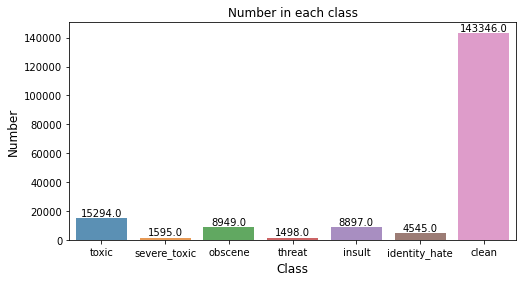

In [158]:
## check the number in each class
x=train_aug.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number in each class")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [50]:
#### SMOTE don't support muti-label

In [159]:
## output the dataset
data_lower.to_csv('data_lower.csv')
balance.to_csv('balance.csv')
train_aug.to_csv('train_aug.csv')

#### Now we have four dataset which are:
    - Orginal 
    - lower the clear data 
    - upsample and downsample
    - augment data
#### SMOTE don't support muti-label so we skip SMOTE

In [2]:
#### load data
train = pd.read_csv('C:\\Users\\admin\\Desktop\\capstone\\project\\train.csv\\train.csv')
train_lower = pd.read_csv('data_lower.csv')
train_up_down = pd.read_csv('balance.csv')
train_aug = pd.read_csv('train_aug.csv')
test = pd.read_csv('test_new.csv')

## Baseline model - LSTM

In [3]:
## set the size of word vector
embed_size = 50 
## how many unique words to use (i.e num rows in embedding vector)
max_features = 20000 
## max number of words in a comment to use
maxlen = 100 
## use the glove embedding, need to download it first
EMBEDDING_FILE = 'C:\\Users\\admin\\Desktop\\capstone\\project\\glove.6B.50d.txt\\glove.6B.50d.txt'

#### Original

In [4]:
## make sure there is no NA values
list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [5]:
## tolenize the comment
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [6]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, 'r',encoding="utf-8"))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [7]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [8]:
## define the model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

Epoch 1/50
437/437 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.8317
Epoch 00001: val_loss improved from inf to 0.05496, saving model to C:\Users\admin\Desktop\capstone\project\original_modelbest.hdf5
437/437 [==============================] - 1052s 2s/step - loss: 0.0920 - accuracy: 0.8317 - val_loss: 0.0550 - val_accuracy: 0.9940
Epoch 2/50
437/437 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9392
Epoch 00002: val_loss improved from 0.05496 to 0.05173, saving model to C:\Users\admin\Desktop\capstone\project\original_modelbest.hdf5
437/437 [==============================] - 1030s 2s/step - loss: 0.0518 - accuracy: 0.9392 - val_loss: 0.0517 - val_accuracy: 0.9940
Epoch 3/50
437/437 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9529
Epoch 00003: val_loss improved from 0.05173 to 0.04803, saving model to C:\Users\admin\Desktop\capstone\project\original_modelbest.hdf5
437/437 [==============================] -

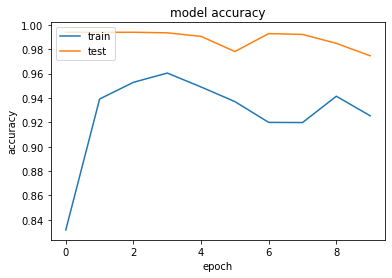

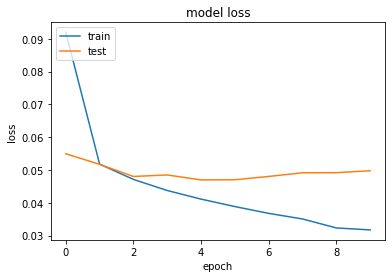

In [9]:
## set the check point to save the best model
checkpoint = ModelCheckpoint(filepath='C:\\Users\\admin\\Desktop\\capstone\\project\\original_modelbest.hdf5',
                             verbose=1,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='auto')
## set the early stop if the val_loss didn't improve
earlystopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=1, 
                              mode='auto')
## reduce the learning rate if the val_loss didn't improve
ReduceL = ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1, 
                      patience=3, 
                      verbose=0, 
                      mode='auto')

## traing the model with 256 batch size, 50 epochm and split the train and val 7:3
history = model.fit(X_t, y,
          batch_size=256, 
          epochs=50, 
          validation_split=0.3,
          callbacks=[earlystopping, checkpoint, ReduceL])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##### The accuracy of train and test (validation) can go up to near 100% and the loss keep improve to near 15 epoch. 

In [10]:
## load best model
model = keras.models.load_model('original_modelbest.hdf5')
## address test
list_sentences_test = test["comment_text"].fillna("_na_").values
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
y = pad_sequences(list_tokenized_test, maxlen=maxlen)
## predict
y_pred = model.predict(y, batch_size=1024, verbose=1)
## caculate the accuracy
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0 
y_true = test[list_classes].values
total = 0
acc = 0
for i in range(len(y_true)):
    for j in range(len(y_true[0])):
        if y_true[i][j] != -1:
            if y_true[i][j] == y_pred[i][j]:
                acc +=1
            total += 1
print('accuracy:', acc/total)

63/63 [==============================] - 5s 85ms/step
accuracy: 0.9679212646013734


#### lower the clear data 

In [11]:
list_sentences_train = train_lower["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_lower[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [12]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [13]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, 'r',encoding="utf-8"))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [14]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [15]:
## define the model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8514
Epoch 00001: val_loss improved from inf to 0.30716, saving model to C:\Users\admin\Desktop\capstone\project\lower_modelbest.hdf5
72/72 [==============================] - 64s 893ms/step - loss: 0.4211 - accuracy: 0.8514 - val_loss: 0.3072 - val_accuracy: 0.9628
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9384
Epoch 00002: val_loss improved from 0.30716 to 0.25061, saving model to C:\Users\admin\Desktop\capstone\project\lower_modelbest.hdf5
72/72 [==============================] - 64s 883ms/step - loss: 0.2801 - accuracy: 0.9384 - val_loss: 0.2506 - val_accuracy: 0.9629
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9464
Epoch 00003: val_loss improved from 0.25061 to 0.23875, saving model to C:\Users\admin\Desktop\capstone\project\lower_modelbest.hdf5
72/72 [==============================] - 66s 919ms/step - l

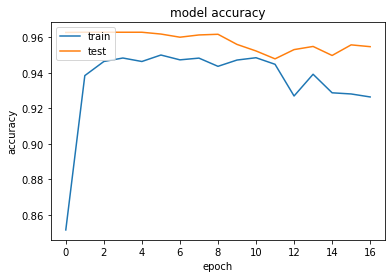

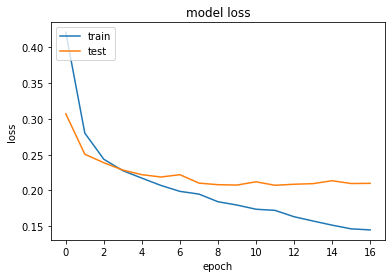

In [17]:
## set the check point to save the best model
checkpoint = ModelCheckpoint(filepath='C:\\Users\\admin\\Desktop\\capstone\\project\\lower_modelbest.hdf5',
                             verbose=1,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='auto')
## set the early stop if the val_loss didn't improve
earlystopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=1, 
                              mode='auto')
## reduce the learning rate if the val_loss didn't improve
ReduceL = ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1, 
                      patience=3, 
                      verbose=0, 
                      mode='auto')

## train the model
history = model.fit(X_t, y,
          batch_size=256, 
          epochs=50, 
          validation_split=0.3,
          callbacks=[earlystopping, checkpoint, ReduceL])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##### The accuracy of train hovering around 95.5% and test (validation) hovering around 92%. The loss also has the same problem. Which shows that lower the clean data is not a good method in this case. 

In [18]:
## load best model
model = keras.models.load_model('lower_modelbest.hdf5')
## address test
list_sentences_test = test["comment_text"].fillna("_na_").values
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
y = pad_sequences(list_tokenized_test, maxlen=maxlen)
## predict
y_pred = model.predict(y, batch_size=1024, verbose=1)
## caculate the accuracy
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0 
y_true = test[list_classes].values
total = 0
acc = 0
for i in range(len(y_true)):
    for j in range(len(y_true[0])):
        if y_true[i][j] != -1:
            if y_true[i][j] == y_pred[i][j]:
                acc +=1
            total += 1
print('accuracy:', acc/total)

63/63 [==============================] - 5s 79ms/step
accuracy: 0.9474116102410204


#### upsample and downsample

In [19]:
list_sentences_train = train_up_down["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_up_down[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [20]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [21]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, 'r',encoding="utf-8"))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [22]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [23]:
## define the model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.7467
Epoch 00001: val_loss improved from inf to 0.19600, saving model to C:\Users\admin\Desktop\capstone\project\up_down_modelbest.hdf5
96/96 [==============================] - 88s 919ms/step - loss: 0.4499 - accuracy: 0.7467 - val_loss: 0.1960 - val_accuracy: 0.8790
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8520
Epoch 00002: val_loss improved from 0.19600 to 0.12609, saving model to C:\Users\admin\Desktop\capstone\project\up_down_modelbest.hdf5
96/96 [==============================] - 91s 949ms/step - loss: 0.3118 - accuracy: 0.8520 - val_loss: 0.1261 - val_accuracy: 0.8155
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.8966
Epoch 00003: val_loss improved from 0.12609 to 0.10429, saving model to C:\Users\admin\Desktop\capstone\project\up_down_modelbest.hdf5
96/96 [==============================] - 83s 860ms/st

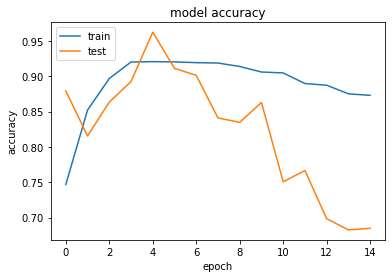

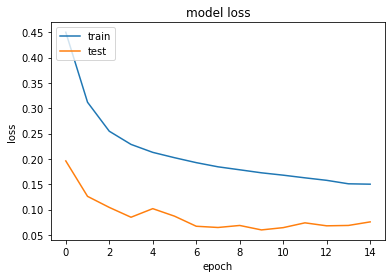

In [24]:
## set the check point to save the best model
checkpoint = ModelCheckpoint(filepath='C:\\Users\\admin\\Desktop\\capstone\\project\\up_down_modelbest.hdf5',
                             verbose=1,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='auto')

## set the early stop if the val_loss didn't improve
earlystopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=1, 
                              mode='auto')
## reducr the learning rate if the val_loss didn't improve
ReduceL = ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1, 
                      patience=3, 
                      verbose=0, 
                      mode='auto')

## train the model
history = model.fit(X_t, y,
          batch_size=256, 
          epochs=50, 
          validation_split=0.3,
          callbacks=[earlystopping, checkpoint, ReduceL])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##### The accuracy of train and test (validation) improve to around 92.5% to 95%. The loss improves to epoch 16 and stop. Compared to the method of lower the clean data, Downsample and upsample perform better but the original data still perform well. 

In [25]:
## load best model
model = keras.models.load_model('up_down_modelbest.hdf5')
## address test
list_sentences_test = test["comment_text"].fillna("_na_").values
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
y = pad_sequences(list_tokenized_test, maxlen=maxlen)
## predict
y_pred = model.predict(y, batch_size=1024, verbose=1)
## caculate the accuracy
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0 
y_true = test[list_classes].values
total = 0
acc = 0
for i in range(len(y_true)):
    for j in range(len(y_true[0])):
        if y_true[i][j] != -1:
            if y_true[i][j] == y_pred[i][j]:
                acc +=1
            total += 1
print('accuracy:', acc/total)

63/63 [==============================] - 5s 79ms/step
accuracy: 0.9442256192232746


#### augment data

In [26]:
list_sentences_train = train_aug["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_aug[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [27]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [28]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, 'r',encoding="utf-8"))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [29]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [30]:
## define the model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.8301
Epoch 00001: val_loss improved from inf to 0.13918, saving model to C:\Users\admin\Desktop\capstone\project\aug_modelbest.hdf5
448/448 [==============================] - 429s 958ms/step - loss: 0.0947 - accuracy: 0.8301 - val_loss: 0.1392 - val_accuracy: 0.9099
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9317
Epoch 00002: val_loss did not improve from 0.13918
448/448 [==============================] - 452s 1s/step - loss: 0.0516 - accuracy: 0.9317 - val_loss: 0.1400 - val_accuracy: 0.9099
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9418
Epoch 00003: val_loss improved from 0.13918 to 0.12230, saving model to C:\Users\admin\Desktop\capstone\project\aug_modelbest.hdf5
448/448 [==============================] - 422s 941ms/step - loss: 0.0469 - accuracy: 0.9418 - val_loss: 0.1223 - val_accuracy: 0.9095
E

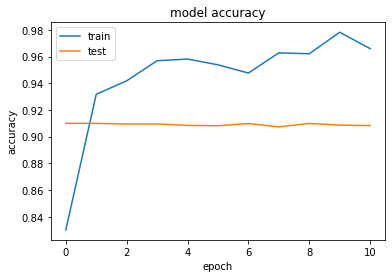

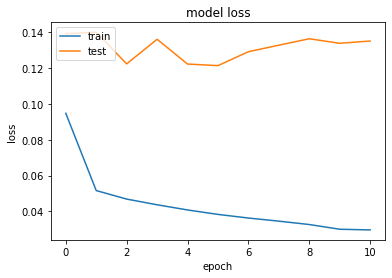

In [31]:
## set the check point to save the best model
checkpoint = ModelCheckpoint(filepath='C:\\Users\\admin\\Desktop\\capstone\\project\\aug_modelbest.hdf5',
                             verbose=1,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='auto')

## set the early stop if the model didn't improve
earlystopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=1, 
                              mode='auto')

## reduce the learning rate if the val_loss didn't improve
ReduceL = ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1, 
                      patience=3, 
                      verbose=0, 
                      mode='auto')

## train the model
history = model.fit(X_t, y,
          batch_size=256, 
          epochs=50, 
          validation_split=0.3,
          callbacks=[earlystopping, checkpoint, ReduceL])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##### The accuracy of train keeps improve but the test (validation) keeps stay around 90%. And the loss has the same situation.  

In [32]:
## load best model
model = keras.models.load_model('aug_modelbest.hdf5')
## address test
list_sentences_test = test["comment_text"].fillna("_na_").values
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
y = pad_sequences(list_tokenized_test, maxlen=maxlen)
## predict
y_pred = model.predict(y, batch_size=1024, verbose=1)
## caculate the accuracy
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0 
y_true = test[list_classes].values
total = 0
acc = 0
for i in range(len(y_true)):
    for j in range(len(y_true[0])):
        if y_true[i][j] != -1:
            if y_true[i][j] == y_pred[i][j]:
                acc +=1
            total += 1
print('accuracy:', acc/total)

63/63 [==============================] - 5s 79ms/step
accuracy: 0.9677753811205936


## BERT 

In [2]:
import os
from typing import Tuple, List
from functools import partial

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

from transformers import TFBertModel

In [3]:
#### load data
train = pd.read_csv('C:\\Users\\admin\\Desktop\\capstone\\project\\train.csv\\train.csv')
train_lower = pd.read_csv('data_lower.csv')
train_up_down = pd.read_csv('balance.csv')
train_aug = pd.read_csv('train_aug.csv')
test = pd.read_csv('test_new.csv')

#### Original

In [4]:
## the class 
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = train
df_test = test
#df_test_labels = pd.read_csv(test_labels_path)
#df_test_labels = df_test_labels.set_index('id')

In [5]:
## select the bert model we want to use
bert_model_name = 'bert-base-cased'

## set the GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
assert tokenizer.pad_token_id == 0, "Padding value used in masks is set to zero, please change it everywhere"

#train_df = pd.read_csv(train_path)
## split train and val
train_df, val_df = train_test_split(df_train, test_size=0.3)
max_seq_len = 128 

In [6]:
## set the data loader to load the data and trainfer to the type that can input to the BERT
class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(tokens) > 120:
            #tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]])
        return x, y
        
    
    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])
            

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)
## data set
train_dataset = ToxicDataset(tokenizer, train_df, lazy=True)
dev_dataset = ToxicDataset(tokenizer, val_df, lazy=True)
collate_fn = partial(collate_fn, device=device)
## batch size
BATCH_SIZE = 8
## load the data 
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(dev_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, sampler=dev_sampler, collate_fn=collate_fn)

In [7]:
## define the bert
class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                
            labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 6
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

model = BertClassifier(BertModel.from_pretrained(bert_model_name), 6).to(device)

In [8]:
## define the train
def train(model, iterator, optimizer, scheduler, loss_train):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print(f"Train loss {total_loss / len(iterator)}")
    loss_train.append(total_loss // len(iterator))
## define evaluate
def evaluate(model, iterator, loss_val):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in tqdm(iterator):
            mask = (x != 0).float()
            loss, outputs = model(x, attention_mask=mask, labels=y)
            total_loss += loss
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)
    for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
    print(f"Evaluate loss {total_loss / len(iterator)}")
    val_loss = total_loss // len(iterator)
    loss_val.append(val_loss)

In [9]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 5
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays 
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=total_steps)

In [10]:
## train
loss_train = []
loss_val = []
for i in range(EPOCH_NUM):
    print('----------------------------' , f"EPOCH {i}", '----------------------------')
    train(model, train_iterator, optimizer, scheduler, loss_train)
    evaluate(model, dev_iterator, loss_val)


  0%|                                                                                                                           | 0/17952 [00:00<?, ?it/s]

---------------------------- EPOCH 0 ----------------------------


  0%|                                                                                                                            | 0/1995 [00:00<?, ?it/s]

Train loss 0.05371485110747321


  0%|                                                                                                                           | 0/17952 [00:00<?, ?it/s]

toxic roc_auc 0.9848761542697391
severe_toxic roc_auc 0.9918090091740318
obscene roc_auc 0.9907814365425236
threat roc_auc 0.9950724014810897
insult roc_auc 0.9858288054417388
identity_hate roc_auc 0.9727442564444829
Evaluate loss 0.0386914387345314
---------------------------- EPOCH 1 ----------------------------


  0%|                                                                                                                            | 0/1995 [00:00<?, ?it/s]

Train loss 0.03493914935099185


  0%|                                                                                                                           | 0/17952 [00:00<?, ?it/s]

toxic roc_auc 0.9854196911293551
severe_toxic roc_auc 0.9923027103409026
obscene roc_auc 0.9922790905166475
threat roc_auc 0.9961865247289077
insult roc_auc 0.986496474518687
identity_hate roc_auc 0.9772195801696189
Evaluate loss 0.04069212079048157
---------------------------- EPOCH 2 ----------------------------


  0%|                                                                                                                            | 0/1995 [00:00<?, ?it/s]

Train loss 0.025605995527234922


  0%|                                                                                                                           | 0/17952 [00:00<?, ?it/s]

toxic roc_auc 0.9845560586164936
severe_toxic roc_auc 0.9923149220305423
obscene roc_auc 0.991798099156821
threat roc_auc 0.9952558846865909
insult roc_auc 0.985792810788894
identity_hate roc_auc 0.9810151997922351
Evaluate loss 0.041658252477645874
---------------------------- EPOCH 3 ----------------------------


  0%|                                                                                                                            | 0/1995 [00:00<?, ?it/s]

Train loss 0.01725672707980817


  0%|                                                                                                                           | 0/17952 [00:00<?, ?it/s]

toxic roc_auc 0.9831857363451526
severe_toxic roc_auc 0.9922608416907084
obscene roc_auc 0.9901605363364154
threat roc_auc 0.9956377281142554
insult roc_auc 0.9859131254093598
identity_hate roc_auc 0.9756607846477351
Evaluate loss 0.048739925026893616
---------------------------- EPOCH 4 ----------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17952/17952 [2:36:47<00:00,  1.91it/s]


Train loss 0.010992153958737056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1995/1995 [05:17<00:00,  6.29it/s]


toxic roc_auc 0.9810502891931856
severe_toxic roc_auc 0.9916358648602089
obscene roc_auc 0.9889992554032029
threat roc_auc 0.9950674424755356
insult roc_auc 0.9852689389900608
identity_hate roc_auc 0.9748894852512028
Evaluate loss 0.05520354211330414


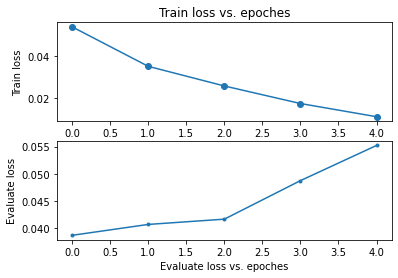

In [1]:
import matplotlib.pyplot as plt
## loss plot
Loss_train = [0.05371485110747321, 0.03493914935099185, 0.025605995527234922, 0.01725672707980817, 0.010992153958737056]
Loss_evaluate = [0.0386914387345314, 0.04069212079048157, 0.041658252477645874, 0.048739925026893616, 0.05520354211330414]
x1 = range(0, 5)
x2 = range(0, 5)
y1 = Loss_train
y2 = Loss_evaluate
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Evaluate loss vs. epoches')
plt.ylabel('Evaluate loss')
plt.show()

##### The loss of train improves but the loss of evaluate (validation) goes up. 

In [13]:
## save model
torch.save(model, 'bert_orginal.pkl')

In [25]:
## predict
test_df = test[['id', 'comment_text']]
submission = test
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    assert (batch_df["id"] == submission["id"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE]).all(), f"Id mismatch"
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(text) > 120:
            #text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs

  0%|                                                                                                                            | 0/7998 [00:00<?, ?it/s]<ipython-input-25-15db9229ca9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7998/7998 [20:19<00:00,  6.56it/s]


In [35]:
## accuracy
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_true = test[list_classes].values
test_pred = submission[list_classes].values
total = 0
acc = 0
for i in range(len(test_true)):
    for j in range(len(test_true[0])):
        if test_true[i][j] != -1:
            if test_true[i][j] == test_pred[i][j]:
                acc +=1
            total += 1
print('accuracy:', acc/total)

accuracy: 1.0


#### lower the clear data 

In [4]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = train_lower
df_test = test

bert_model_name = 'bert-base-cased'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
assert tokenizer.pad_token_id == 0, "Padding value used in masks is set to zero, please change it everywhere"

#train_df = pd.read_csv(train_path)

train_df, val_df = train_test_split(df_train, test_size=0.3)

max_seq_len = 128 


class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(tokens) > 120:
            #tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]])
        return x, y
        
    
    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])
            

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

train_dataset = ToxicDataset(tokenizer, train_df, lazy=True)
dev_dataset = ToxicDataset(tokenizer, val_df, lazy=True)
collate_fn = partial(collate_fn, device=device)
BATCH_SIZE = 8
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(dev_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, sampler=dev_sampler, collate_fn=collate_fn)

class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                
            labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 6
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

model = BertClassifier(BertModel.from_pretrained(bert_model_name), 6).to(device)

def train(model, iterator, optimizer, scheduler, loss_train):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print(f"Train loss {total_loss / len(iterator)}")
    loss_train.append(total_loss // len(iterator))

def evaluate(model, iterator, loss_val):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in tqdm(iterator):
            mask = (x != 0).float()
            loss, outputs = model(x, attention_mask=mask, labels=y)
            total_loss += loss
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)
    for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
    print(f"Evaluate loss {total_loss / len(iterator)}")
    val_loss = total_loss // len(iterator)
    loss_val.append(val_loss)
    
    
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 5
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays 
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=total_steps)

In [5]:
## train
loss_train = []
loss_val = []
for i in range(EPOCH_NUM):
    print('----------------------------' , f"EPOCH {i}", '----------------------------')
    train(model, train_iterator, optimizer, scheduler, loss_train)
    evaluate(model, dev_iterator, loss_val)

## save model
torch.save(model, 'bert_lower.pkl')

  0%|                                                                                                                                   | 0/2295 [00:00<?, ?it/s]

---------------------------- EPOCH 0 ----------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2295/2295 [19:14<00:00,  1.99it/s]


Train loss 0.27326929358388086


  0%|                                                                                                                                   | 0/2295 [00:00<?, ?it/s]

toxic roc_auc 0.964415902147181
severe_toxic roc_auc 0.9437390999216754
obscene roc_auc 0.9596804272272612
threat roc_auc 0.8737786127666927
insult roc_auc 0.9216090816859004
identity_hate roc_auc 0.8992510399892647
Evaluate loss 0.1969003826379776
---------------------------- EPOCH 1 ----------------------------


  0%|                                                                                                                                    | 0/984 [00:00<?, ?it/s]

Train loss 0.17559432678557688


  0%|                                                                                                                                   | 0/2295 [00:00<?, ?it/s]

toxic roc_auc 0.967433601340499
severe_toxic roc_auc 0.9436423330398576
obscene roc_auc 0.9624968584043818
threat roc_auc 0.9462650082059256
insult roc_auc 0.9258327950199708
identity_hate roc_auc 0.9399906194516702
Evaluate loss 0.17986412346363068
---------------------------- EPOCH 2 ----------------------------


  0%|                                                                                                                                    | 0/984 [00:00<?, ?it/s]

Train loss 0.13625585961100808


  0%|                                                                                                                                   | 0/2295 [00:00<?, ?it/s]

toxic roc_auc 0.9657513603138754
severe_toxic roc_auc 0.941297151078088
obscene roc_auc 0.9596421332215
threat roc_auc 0.9464913189945582
insult roc_auc 0.9249571774145052
identity_hate roc_auc 0.9473666723440274
Evaluate loss 0.19019529223442078
---------------------------- EPOCH 3 ----------------------------


  0%|                                                                                                                                    | 0/984 [00:00<?, ?it/s]

Train loss 0.10378602698063863


  0%|                                                                                                                                   | 0/2295 [00:00<?, ?it/s]

toxic roc_auc 0.9631233720341985
severe_toxic roc_auc 0.9428796554049894
obscene roc_auc 0.9590986929475083
threat roc_auc 0.9426561285307073
insult roc_auc 0.9230858643760705
identity_hate roc_auc 0.9484953703703705
Evaluate loss 0.1991410106420517
---------------------------- EPOCH 4 ----------------------------


  0%|                                                                                                                                    | 0/984 [00:00<?, ?it/s]

Train loss 0.08205746578981933


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 984/984 [02:32<00:00,  6.46it/s]


toxic roc_auc 0.9602272081130099
severe_toxic roc_auc 0.9426898487537778
obscene roc_auc 0.9585105267619333
threat roc_auc 0.9411419193227952
insult roc_auc 0.9218560656761701
identity_hate roc_auc 0.9460908790618936
Evaluate loss 0.20695072412490845


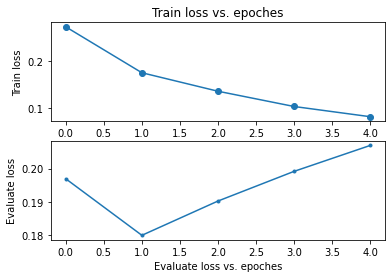

In [2]:
## loss plot
Loss_train = [0.27326929358388086, 0.17559432678557688, 0.13625585961100808, 0.10378602698063863, 0.08205746578981933]
Loss_evaluate = [0.1969003826379776, 0.17986412346363068, 0.19019529223442078, 0.1991410106420517, 0.20695072412490845]
x1 = range(0, 5)
x2 = range(0, 5)
y1 = Loss_train
y2 = Loss_evaluate
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Evaluate loss vs. epoches')
plt.ylabel('Evaluate loss')
plt.show()

##### The loss of train improves but the loss of evaluate (validation) goes up. 

In [6]:
## predict
test_df = test[['id', 'comment_text']]
submission = test
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    assert (batch_df["id"] == submission["id"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE]).all(), f"Id mismatch"
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(text) > 120:
            #text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs

## accuracy
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_true = test[list_classes].values
test_pred = submission[list_classes].values
total = 0
acc = 0
for i in range(len(test_true)):
    for j in range(len(test_true[0])):
        if test_true[i][j] != -1:
            if test_true[i][j] == test_pred[i][j]:
                acc +=1
            total += 1
print('accuracy train_lower:', acc/total)

  0%|                                                                                                                                   | 0/7998 [00:00<?, ?it/s]<ipython-input-6-961037f75156>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|███████████████████████████████████████████████████████████████████

accuracy train_lower: 1.0


#### upsample and downsample

In [7]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = train_up_down
df_test = test

bert_model_name = 'bert-base-cased'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
assert tokenizer.pad_token_id == 0, "Padding value used in masks is set to zero, please change it everywhere"

#train_df = pd.read_csv(train_path)

train_df, val_df = train_test_split(df_train, test_size=0.3)

max_seq_len = 128 


class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(tokens) > 120:
            #tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]])
        return x, y
        
    
    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])
            

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

train_dataset = ToxicDataset(tokenizer, train_df, lazy=True)
dev_dataset = ToxicDataset(tokenizer, val_df, lazy=True)
collate_fn = partial(collate_fn, device=device)
BATCH_SIZE = 8
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(dev_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, sampler=dev_sampler, collate_fn=collate_fn)

class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                
            labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 6
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

model = BertClassifier(BertModel.from_pretrained(bert_model_name), 6).to(device)

def train(model, iterator, optimizer, scheduler, loss_train):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print(f"Train loss {total_loss / len(iterator)}")
    loss_train.append(total_loss // len(iterator))

def evaluate(model, iterator, loss_val):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in tqdm(iterator):
            mask = (x != 0).float()
            loss, outputs = model(x, attention_mask=mask, labels=y)
            total_loss += loss
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)
    for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
    print(f"Evaluate loss {total_loss / len(iterator)}")
    val_loss = total_loss // len(iterator)
    loss_val.append(val_loss)
    
    
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 5
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays 
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=total_steps)

In [8]:
## train
loss_train = []
loss_val = []
for i in range(EPOCH_NUM):
    print('----------------------------' , f"EPOCH {i}", '----------------------------')
    train(model, train_iterator, optimizer, scheduler, loss_train)
    evaluate(model, dev_iterator, loss_val)

## save model
torch.save(model, 'bert_train_up_down.pkl')

  0%|                                                                                                                           | 1/3065 [00:00<07:32,  6.77it/s]

---------------------------- EPOCH 0 ----------------------------


  0%|                                                                                                                                   | 0/1314 [00:00<?, ?it/s]

Train loss 0.23207028850922162


  0%|                                                                                                                                   | 0/3065 [00:00<?, ?it/s]

toxic roc_auc 0.9750015998658319
severe_toxic roc_auc 0.9535203997682895
obscene roc_auc 0.9711495758336657
threat roc_auc 0.9855607215798948
insult roc_auc 0.9481839552732205
identity_hate roc_auc 0.9806865981075426
Evaluate loss 0.14512094855308533
---------------------------- EPOCH 1 ----------------------------


  0%|                                                                                                                                   | 0/1314 [00:00<?, ?it/s]

Train loss 0.12850435296602267


  0%|                                                                                                                           | 1/3065 [00:00<07:20,  6.96it/s]

toxic roc_auc 0.9781690399848768
severe_toxic roc_auc 0.9539291922281483
obscene roc_auc 0.9740557703439483
threat roc_auc 0.9868787429036276
insult roc_auc 0.9508706586891684
identity_hate roc_auc 0.9842911175108304
Evaluate loss 0.14111189544200897
---------------------------- EPOCH 2 ----------------------------


  0%|                                                                                                                                   | 0/1314 [00:00<?, ?it/s]

Train loss 0.09736662930398754


  0%|                                                                                                                                   | 0/3065 [00:00<?, ?it/s]

toxic roc_auc 0.9762237134688108
severe_toxic roc_auc 0.9558141455305255
obscene roc_auc 0.9731957775013884
threat roc_auc 0.9882560448975353
insult roc_auc 0.9480500617380649
identity_hate roc_auc 0.9852209326676444
Evaluate loss 0.1507434993982315
---------------------------- EPOCH 3 ----------------------------


  0%|                                                                                                                                   | 0/1314 [00:00<?, ?it/s]

Train loss 0.07005589332471056


  0%|                                                                                                                                   | 0/3065 [00:00<?, ?it/s]

toxic roc_auc 0.9715032081907246
severe_toxic roc_auc 0.9523284470169112
obscene roc_auc 0.9717834541884713
threat roc_auc 0.9880238983314871
insult roc_auc 0.9448276802672259
identity_hate roc_auc 0.9811447043648756
Evaluate loss 0.16710655391216278
---------------------------- EPOCH 4 ----------------------------


  0%|                                                                                                                                   | 0/1314 [00:00<?, ?it/s]

Train loss 0.051094653074694935


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1314/1314 [03:20<00:00,  6.56it/s]


toxic roc_auc 0.9695692646281064
severe_toxic roc_auc 0.9512272687315569
obscene roc_auc 0.9709310392368526
threat roc_auc 0.9874031821171421
insult roc_auc 0.9431328125669759
identity_hate roc_auc 0.9801649977896835
Evaluate loss 0.1746567338705063


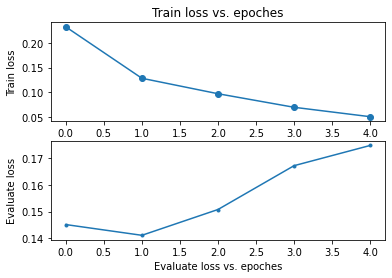

In [3]:
## loss plot
Loss_train = [0.23207028850922162, 0.12850435296602267, 0.09736662930398754, 0.07005589332471056, 0.051094653074694935]
Loss_evaluate = [0.14512094855308533, 0.14111189544200897, 0.1507434993982315, 0.16710655391216278, 0.1746567338705063]
x1 = range(0, 5)
x2 = range(0, 5)
y1 = Loss_train
y2 = Loss_evaluate
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Evaluate loss vs. epoches')
plt.ylabel('Evaluate loss')
plt.show()

##### The loss of train improves but the loss of evaluate (validation) goes up. 

In [9]:
## predict
test_df = test[['id', 'comment_text']]
submission = test
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    assert (batch_df["id"] == submission["id"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE]).all(), f"Id mismatch"
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(text) > 120:
            #text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs

## accuracy
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_true = test[list_classes].values
test_pred = submission[list_classes].values
total = 0
acc = 0
for i in range(len(test_true)):
    for j in range(len(test_true[0])):
        if test_true[i][j] != -1:
            if test_true[i][j] == test_pred[i][j]:
                acc +=1
            total += 1
print('accuracy train_up_down:', acc/total)

  0%|                                                                                                                                   | 0/7998 [00:00<?, ?it/s]<ipython-input-9-db00cd1095f8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|███████████████████████████████████████████████████████████████████

accuracy train_up_down: 1.0


#### augment data

In [10]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = train_aug
df_test = test

bert_model_name = 'bert-base-cased'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
assert tokenizer.pad_token_id == 0, "Padding value used in masks is set to zero, please change it everywhere"

#train_df = pd.read_csv(train_path)

train_df, val_df = train_test_split(df_train, test_size=0.3)

max_seq_len = 128 


class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame, lazy: bool = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        if not self.lazy:
            self.X = []
            self.Y = []
            for i, (row) in tqdm(dataframe.iterrows()):
                x, y = self.row_to_tensor(self.tokenizer, row)
                self.X.append(x)
                self.Y.append(y)
        else:
            self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row["comment_text"], add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(tokens) > 120:
            #tokens = tokens[:119] + [tokens[-1]]
        x = torch.LongTensor(tokens)
        y = torch.FloatTensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]])
        return x, y
        
    
    def __len__(self):
        if self.lazy:
            return len(self.df)
        else:
            return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        if not self.lazy:
            return self.X[index], self.Y[index]
        else:
            return self.row_to_tensor(self.tokenizer, self.df.iloc[index])
            

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

train_dataset = ToxicDataset(tokenizer, train_df, lazy=True)
dev_dataset = ToxicDataset(tokenizer, val_df, lazy=True)
collate_fn = partial(collate_fn, device=device)
BATCH_SIZE = 8
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(dev_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
dev_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, sampler=dev_sampler, collate_fn=collate_fn)

class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                
            labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] # batch, hidden
        cls_output = self.classifier(cls_output) # batch, 6
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

model = BertClassifier(BertModel.from_pretrained(bert_model_name), 6).to(device)

def train(model, iterator, optimizer, scheduler, loss_train):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print(f"Train loss {total_loss / len(iterator)}")
    loss_train.append(total_loss // len(iterator))

def evaluate(model, iterator, loss_val):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in tqdm(iterator):
            mask = (x != 0).float()
            loss, outputs = model(x, attention_mask=mask, labels=y)
            total_loss += loss
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)
    for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
    print(f"Evaluate loss {total_loss / len(iterator)}")
    val_loss = total_loss // len(iterator)
    loss_val.append(val_loss)
    
    
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 5
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays 
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=total_steps)

In [11]:
## train
loss_train = []
loss_val = []
for i in range(EPOCH_NUM):
    print('----------------------------' , f"EPOCH {i}", '----------------------------')
    train(model, train_iterator, optimizer, scheduler, loss_train)
    evaluate(model, dev_iterator, loss_val)

## save model
torch.save(model, 'bert_train_aug.pkl')

  0%|                                                                                                                                  | 0/14327 [00:00<?, ?it/s]

---------------------------- EPOCH 0 ----------------------------


  0%|                                                                                                                                   | 0/6140 [00:00<?, ?it/s]

Train loss 0.06452774089625292


  0%|                                                                                                                                  | 0/14327 [00:00<?, ?it/s]

toxic roc_auc 0.98129977258801
severe_toxic roc_auc 0.990735304576296
obscene roc_auc 0.9905490715363533
threat roc_auc 0.9970139877588763
insult roc_auc 0.9875918356404643
identity_hate roc_auc 0.993921774290079
Evaluate loss 0.04411051422357559
---------------------------- EPOCH 1 ----------------------------


  0%|                                                                                                                                   | 0/6140 [00:00<?, ?it/s]

Train loss 0.03558191595835051


  0%|                                                                                                                                  | 0/14327 [00:00<?, ?it/s]

toxic roc_auc 0.9841577765067887
severe_toxic roc_auc 0.989174682269084
obscene roc_auc 0.9921288928790546
threat roc_auc 0.9977740619598219
insult roc_auc 0.9895509941273073
identity_hate roc_auc 0.995992838619178
Evaluate loss 0.04043671116232872
---------------------------- EPOCH 2 ----------------------------


  0%|                                                                                                                                   | 0/6140 [00:00<?, ?it/s]

Train loss 0.024835799867587518


  0%|                                                                                                                                  | 0/14327 [00:00<?, ?it/s]

toxic roc_auc 0.9821357916570091
severe_toxic roc_auc 0.9896889094867818
obscene roc_auc 0.9918174586066374
threat roc_auc 0.9945955246849113
insult roc_auc 0.989160890693796
identity_hate roc_auc 0.9958819573873465
Evaluate loss 0.04307328537106514
---------------------------- EPOCH 3 ----------------------------


  0%|                                                                                                                           | 1/6140 [00:00<17:20,  5.90it/s]

Train loss 0.016502077261136026


  0%|                                                                                                                                  | 0/14327 [00:00<?, ?it/s]

toxic roc_auc 0.9789761414001512
severe_toxic roc_auc 0.9889533426679101
obscene roc_auc 0.9912060196755175
threat roc_auc 0.9954233642654479
insult roc_auc 0.9870809275111874
identity_hate roc_auc 0.99423533524778
Evaluate loss 0.04958465322852135
---------------------------- EPOCH 4 ----------------------------


  0%|                                                                                                                                   | 0/6140 [00:00<?, ?it/s]

Train loss 0.009867779444672063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6140/6140 [15:49<00:00,  6.46it/s]


toxic roc_auc 0.9781164195500984
severe_toxic roc_auc 0.9883594984325319
obscene roc_auc 0.9899468947377978
threat roc_auc 0.9952353328373055
insult roc_auc 0.9817893872103215
identity_hate roc_auc 0.9935371450067347
Evaluate loss 0.05808599293231964


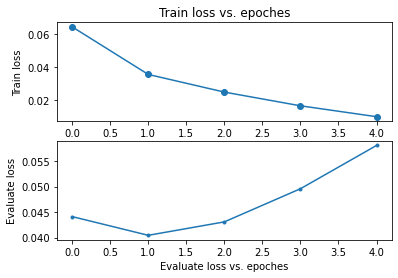

In [4]:
## loss plot
Loss_train = [0.06452774089625292, 0.03558191595835051, 0.024835799867587518, 0.016502077261136026, 0.009867779444672063]
Loss_evaluate = [0.04411051422357559, 0.04043671116232872, 0.04307328537106514, 0.04958465322852135, 0.05808599293231964]
x1 = range(0, 5)
x2 = range(0, 5)
y1 = Loss_train
y2 = Loss_evaluate
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Evaluate loss vs. epoches')
plt.ylabel('Evaluate loss')
plt.show()

##### The loss of train improves but the loss of evaluate (validation) goes up. 

In [12]:
## predict
test_df = test[['id', 'comment_text']]
submission = test
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    assert (batch_df["id"] == submission["id"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE]).all(), f"Id mismatch"
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True, max_length = max_seq_len, truncation=True)
        #if len(text) > 120:
            #text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs

## accuracy
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_true = test[list_classes].values
test_pred = submission[list_classes].values
total = 0
acc = 0
for i in range(len(test_true)):
    for j in range(len(test_true[0])):
        if test_true[i][j] != -1:
            if test_true[i][j] == test_pred[i][j]:
                acc +=1
            total += 1
print('accuracy train_aug:', acc/total)

  0%|                                                                                                                                   | 0/7998 [00:00<?, ?it/s]<ipython-input-12-15ab5e2cd81a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████████████████████████████████████████████████████████████

accuracy train_aug: 1.0


## Summary
#### Accuracy on testing dataset 
|      |  Original Dataset    | Lower the clean data  |  Downsample and upsample    | Augmentation  |
|  ----  | ----  |  ----  | ----  | ----  |
| LSTM  | 96.9  | 95.1   | 94.3 | 96.8 |
| BERT  | 100 | 100  | 100 | 100 |

#### For LSTM model, the original dataset have the best performance on training process and Testing. This may related to the distribution of the training dataset and testing dataset. Because they have similar composition, and we think this distribution meets the situation in the real scenario. Most of the content on the website are more neutral, toxic are less. If we train a model with more toxic data, then it may imply many content on the internet are toxic. Bert model performs relatively well compare our baseline model, and the testing accuracy on all dataset are 100%. This task are easy from BERT, the only problem is that it may be too big to run on Chrome extension.